# Abstract
In this blog post we will investigate the predictive power of song lyrics and engineered features. We will be trying to predict the genre of a song using its lyrics and the features. We will first train a model on just the lyrics, then on just the features, and finally on both. We will compare the results and see if there is any improvement when using both features and lyrics. For the lyrics we will use BERT embeddings which will be plugged into a neural network similar to the engineered features. For the combined model we will concatenate the results from both the lyrics and the features before passing them through a final couple of layers. We will end by examining the embeddings of the lyrics and the features to see if there are any interesting patterns.

In [155]:
#| include: false

import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
from transformers import BertTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data
The data we will be using is from Spotify and contains information about songs, their lyrics, and their features. As we can see below, the data has a lot of information about the songs including the genre which we will be using as our target variable.

In [156]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


Now that we have the data, one interesting thing we can do is explore some of the engineered features and genres. An interesting question to ask is whether pop music has gotten more danceable over the years. Since we have release date information as will as a dancability measure we can group by year and calculate the mean dancability after filtering for just pop data.

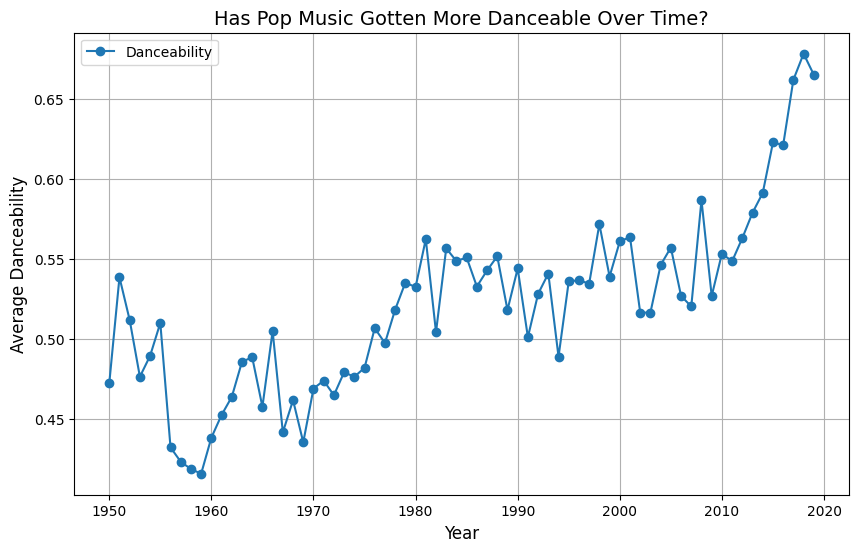

In [157]:
pop_data = df[df['genre'] == 'pop']
pop_danceability = pop_data.groupby('release_date')['danceability'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(pop_danceability['release_date'], pop_danceability['danceability'], marker='o', label='Danceability')
plt.title('Has Pop Music Gotten More Danceable Over Time?', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

As we can see, it appears that pop music has gotten more danceable over the years. This is an interesting finding and shows that we can use the engineered features to gain insights into the data.


### Preprocessing
As the genre is a string, we will need to convert it to a number for the model to be able to use it. We will do this by using the `LabelEncoder` from `sklearn`. This will allow us to map the genres to numbers which will serve as our categories for the target variable. We output the count of each genre along with its mapping to see the imbalance in the data.

In [158]:
label_encoder = LabelEncoder()
df['genre_numeric'] = label_encoder.fit_transform(df['genre'])

genre_mapping = dict(enumerate(label_encoder.classes_))

genre_counts = df['genre_numeric'].value_counts().reset_index()
genre_counts.columns = ['genre_numeric', 'count']
genre_counts['genre_name'] = genre_counts['genre_numeric'].map(genre_mapping)

display(genre_counts)

,genre_numeric,count,genre_name
0,4,7042,pop
1,1,5445,country
2,0,4604,blues
3,6,4034,rock
4,3,3845,jazz
5,5,2498,reggae
6,2,904,hip hop


As we can see, the data is relatively imbalanced with pop as the most common genre. We will use this distribution to compute our baseline accuracy which will be the accuracy of the most common genre. The following code does this and we see that the baseline accuracy is 0.248. This is important to keep in mind when we are evaluating our models as we will need to beat this accuracy to show that our models are actually learning something. If we simply predict pop every time we will achieve an accuracy of 0.248 so we expect our models to do better than this.

In [159]:
print(f"Base Rate: {max(genre_counts['count']) / sum(genre_counts['count'])}")

Base Rate: 0.24820245312279712


# Embeddings
Now that we better understand the data, the next step is to create the embeddings for the lyrics. We will use the `BertTokenizer` from Google to create the embeddings. To do this we first have to preprocess the lyrics by padding them out to the same length. This has the effect of adding padding tokens to the end of the embeddings so they are all the same size and can be used in the model. After splitting the date into training and validation sets we will preprocess the lyrics so that we have the embeddings ready to be used in the models.

In [160]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
max_len = 512

def pad(l, max_len):
    if len(l) <= max_len:
        to_add = max_len - len(l)
        return l + [0]*to_add
    else:
        return l[:max_len]

def preprocess(df, tokenizer, max_len):
    X = tokenizer(list(df["lyrics"]))["input_ids"]
    X = [pad(t, max_len) for t in X]
    y = list(df["genre_numeric"])
    return X, y

class TextDataFromDF(Dataset):
    def __init__(self, df):
        self.X, self.y = preprocess(df, tokenizer, max_len)

    def __getitem__(self, ix):
        return self.X[ix], self.y[ix]

    def __len__(self):
        return len(self.y)
    
train_lyrics = TextDataFromDF(train_df)
val_lyrics   = TextDataFromDF(val_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors


# Model 1
In order to create models we first have to create data loaders for the training and validation sets. We will use the `DataLoader` from `torch` to do this. We will use the same dataloader for all of the models. Finally we define the model which is a simple feed forward neural network with three hidden layers after the embeddings.

In [161]:
def collate(data):
    lyrics = torch.tensor([d[0] for d in data])
    features = torch.tensor([d[2] for d in data])
    y = torch.tensor([d[1] for d in data])
    return lyrics, features, y 

engineered_features = ['dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']      
train_features = train_df[engineered_features].values.tolist()
val_features = val_df[engineered_features].values.tolist()
train_data = [(train_lyrics[i][0], train_lyrics[i][1], train_features[i]) for i in range(len(train_lyrics))]
val_data = [(val_lyrics[i][0], val_lyrics[i][1], val_features[i]) for i in range(len(val_lyrics))]

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn = collate)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, collate_fn = collate)

class TextClassificationModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, max_len, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.fc1 = nn.Linear(max_len * embedding_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_class)

    def forward(self, lyrics, features):
        x = self.embedding(lyrics)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

vocab_size = len(tokenizer.vocab)
embedding_dim = 25
num_class = max(df["genre_numeric"]) + 1

lyrics_model = TextClassificationModel(vocab_size, embedding_dim, max_len, num_class).to(device)

With the model defined we can now train it. We define a training function to use the dataloader and pass the lyrics through the model. We will use the `Adam` optimizer and the `CrossEntropyLoss` loss function. We will train the model for 20 epochs and print the loss and the time taken for each epoch. Afterward we will evaluate the model on the validation set and print the accuracy. 

In [162]:
optimizer = torch.optim.Adam(lyrics_model.parameters(), lr=.001)
loss_fn = torch.nn.CrossEntropyLoss()

def train(dataloader, model):
    epoch_start_time = time.time()
    total_acc, total_count = 0, 0
    
    for lyrics, features, y in dataloader:
        optimizer.zero_grad()
        predicted_label = model(lyrics, features)
        loss = loss_fn(predicted_label, y)
        loss.backward()
        optimizer.step()
                
        total_acc   += (predicted_label.argmax(1) == y).sum().item()
        total_count += y.size(0)

    print(f'| epoch {epoch:3d} | train accuracy {total_acc/total_count:8.3f} | time: {time.time() - epoch_start_time:5.2f}s')

def accuracy(dataloader, model):

    total_acc, total_count = 0, 0

    with torch.no_grad():
        for lyrics, features, y in dataloader:
            predicted_label = model(lyrics, features)
            total_acc += (predicted_label.argmax(1) == y).sum().item()
            total_count += y.size(0)
    return total_acc/total_count

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    train(train_loader, lyrics_model)

print(f'validation accuracy: {accuracy(val_loader, lyrics_model)}')

| epoch   1 | train accuracy    0.223 | time: 17.40s
| epoch   2 | train accuracy    0.294 | time: 17.25s
| epoch   3 | train accuracy    0.399 | time: 17.31s
| epoch   4 | train accuracy    0.489 | time: 17.26s
| epoch   5 | train accuracy    0.558 | time: 17.29s
| epoch   6 | train accuracy    0.617 | time: 17.30s
| epoch   7 | train accuracy    0.665 | time: 17.32s
| epoch   8 | train accuracy    0.706 | time: 17.78s
| epoch   9 | train accuracy    0.743 | time: 17.25s
| epoch  10 | train accuracy    0.784 | time: 17.18s
| epoch  11 | train accuracy    0.816 | time: 17.14s
| epoch  12 | train accuracy    0.843 | time: 17.23s
| epoch  13 | train accuracy    0.870 | time: 17.20s
| epoch  14 | train accuracy    0.889 | time: 17.29s
| epoch  15 | train accuracy    0.906 | time: 17.32s
| epoch  16 | train accuracy    0.923 | time: 17.29s
| epoch  17 | train accuracy    0.935 | time: 17.26s
| epoch  18 | train accuracy    0.944 | time: 17.39s
| epoch  19 | train accuracy    0.951 | time: 

As we can see, the model improves over time but the accuracy on the validation set is not very high. This indicates that the model is likely overfitting to the training set. That said, it still manages to achieve an accuracy of 0.254 which is better than the baseline accuracy. This shows that the model is learning something from the lyrics and is able to predict the genre of the song to a marginal extent.

# Model 2
The second model will be similar to the first but will use the engineered features instead of the lyrics. We will use similar data loaders and the same training function as before. This model has 3 hidden layers and uses the `ReLU` activation function. We will train the model for 20 epochs and print the loss and the time taken for each epoch. Afterward we will evaluate the model on the validation set.

In [163]:
class EngineeredFeaturesModel(nn.Module):
    def __init__(self, num_features, num_class):
        super().__init__()
        self.pipeline = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_class),
        )

    def forward(self, lyrics, features):
        return self.pipeline(features)

num_features = len(engineered_features)
engineered_model = EngineeredFeaturesModel(num_features, num_class).to(device)

optimizer = torch.optim.Adam(engineered_model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    train(train_loader, engineered_model)

val_acc = accuracy(val_loader, engineered_model)
print(f'Validation accuracy: {val_acc:.3f}')

| epoch   1 | train accuracy    0.344 | time:  2.57s
| epoch   2 | train accuracy    0.368 | time:  2.47s
| epoch   3 | train accuracy    0.375 | time:  2.51s
| epoch   4 | train accuracy    0.377 | time:  2.47s
| epoch   5 | train accuracy    0.380 | time:  2.52s
| epoch   6 | train accuracy    0.383 | time:  2.47s
| epoch   7 | train accuracy    0.381 | time:  2.50s
| epoch   8 | train accuracy    0.383 | time:  2.50s
| epoch   9 | train accuracy    0.383 | time:  2.50s
| epoch  10 | train accuracy    0.387 | time:  2.47s
| epoch  11 | train accuracy    0.388 | time:  2.50s
| epoch  12 | train accuracy    0.387 | time:  2.46s
| epoch  13 | train accuracy    0.389 | time:  2.50s
| epoch  14 | train accuracy    0.388 | time:  2.46s
| epoch  15 | train accuracy    0.386 | time:  2.49s
| epoch  16 | train accuracy    0.391 | time:  2.46s
| epoch  17 | train accuracy    0.390 | time:  2.50s
| epoch  18 | train accuracy    0.392 | time:  2.53s
| epoch  19 | train accuracy    0.393 | time: 

As we we can see the model is able to achieve an accuracy on the validation set of 0.378 which is better than the first model. This may show that the features are more informative than the lyrics. On this one, the validation accuracy does not diverge from the training accuracy as much as the first model which indicates that the model is not overfitting as much.

# Model 3
The third model will be a combination of the first two models. We will concatenate the results from the lyrics and the features before passing them through a final couple of layers. The lyrics model has 2 hidden layers and the features model has 3 hidden layers. Both use the `ReLU` activation function. We will train the model for 20 epochs and print the loss and the time taken for each epoch. Afterward we will evaluate the model on the validation set.

In [164]:
class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len, num_features, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.linear_fc = nn.Sequential(
            nn.Linear(max_len * embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.lyrics_fc = nn.Linear(128, 64)

        self.engineered_pipeline = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_class)

    def forward(self, lyrics, features):
        lyrics_embeddings = self.embedding(lyrics)
        lyrics_x = torch.mean(lyrics_embeddings, dim=1)
        lyrics_x = torch.flatten(lyrics_embeddings, 1)
        lyrics_x = self.linear_fc(lyrics_x)
        lyrics_out = self.lyrics_fc(lyrics_x)

        features_out = self.engineered_pipeline(features)

        combined_out = torch.cat((lyrics_out, features_out), dim=1)

        combined_out = self.fc1(combined_out)
        combined_out = self.fc2(combined_out)
        return combined_out

combined_model = CombinedModel(vocab_size, embedding_dim, max_len, num_features, num_class).to(device)

optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

EPOCHS = 20
for epoch in range(0, EPOCHS):
    train(train_loader, combined_model)

val_acc = accuracy(val_loader, combined_model)
print(f'Validation accuracy: {val_acc:.3f}')

| epoch   0 | train accuracy    0.332 | time: 19.85s
| epoch   1 | train accuracy    0.364 | time: 19.62s
| epoch   2 | train accuracy    0.375 | time: 19.67s
| epoch   3 | train accuracy    0.376 | time: 19.63s
| epoch   4 | train accuracy    0.379 | time: 19.60s
| epoch   5 | train accuracy    0.385 | time: 19.61s
| epoch   6 | train accuracy    0.384 | time: 19.72s
| epoch   7 | train accuracy    0.388 | time: 19.76s
| epoch   8 | train accuracy    0.390 | time: 19.37s
| epoch   9 | train accuracy    0.389 | time: 19.67s
| epoch  10 | train accuracy    0.391 | time: 19.51s
| epoch  11 | train accuracy    0.395 | time: 19.45s
| epoch  12 | train accuracy    0.397 | time: 19.34s
| epoch  13 | train accuracy    0.396 | time: 20.14s
| epoch  14 | train accuracy    0.395 | time: 19.63s
| epoch  15 | train accuracy    0.399 | time: 19.61s
| epoch  16 | train accuracy    0.402 | time: 19.89s
| epoch  17 | train accuracy    0.401 | time: 19.45s
| epoch  18 | train accuracy    0.400 | time: 

As we can see the model improves slightly over the epochs though it takes a lot longer. The results on the validation set are slightly better than the second model but that is likely not significant. It is likely that we could have achieved better results with more tinkering to optimize the layers as the final accuracy of 0.382 is not very good. That said it is higher than the baseline accuracy so it is still a step in the right direction.

# Examining the Embeddings
The final step is to extract the embedding from the model and examine them to look for patterns. We will use Plotly for interactive plotting and PCA to reduce the dimensionality of the embeddings so we can plot them. While we are able to plot the embeddings we do not see many clear patterns. The words are pretty evenly distributed and there are no clear clusters.

In [165]:
embedding_matrix = combined_model.embedding.cpu().weight.data.numpy()
tokens = list(tokenizer.vocab.keys())

pca = PCA(n_components=2)
weights = pca.fit_transform(embedding_matrix)

tokens.append(" ")
embedding_df = pd.DataFrame({
    'word' : tokens,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 10,
                 hover_name = "word")

fig.show()

# Discussion
In this blog post we examined the feasibility of using song lyrics and engineered features to predict the genre of a song. We trained three models, one on just the lyrics, one on just the features, and one on both. We found that the model trained on the features performed better than the one trained on the lyrics. The combined model performed slightly better than the features model but not significantly so. We also examined the embeddings from the models and did not find any clear patterns. Overall, this shows that while it is possible to use song lyrics and engineered features to predict the genre of a song, there is still a lot of room for improvement in our methods.